## Temperature Inversion Analysis
Exploratory analysis of temperature inversions seen between `TREFHT` and the lowest model levels in CESM.

In [2]:
import pandas as pd
import xarray as xr
import numpy as np
import sys


sys.path.append('/home/users/jamd1/Isca/')
from isca_tools import cesm
from isca_tools.utils import area_weighting, lat_lon_rolling, print_ds_var_list, set_attrs
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.utils.moist_physics import moist_static_energy, sphum_sat
from isca_tools.utils.constants import g, c_p, lapse_dry
from isca_tools.convection.base import lcl_metpy
import isca_tools
import cftime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
import matplotlib.patches as patches
from tqdm.notebook import tqdm
import matplotlib
from matplotlib.dates import ConciseDateConverter
matplotlib.units.registry[cftime.DatetimeNoLeap] = ConciseDateConverter()  # to allow plotting time as x axis
plt.style.use('/home/users/jamd1/Isca/jobs/publish.mplstyle')
import os
from numba import jit
import metpy
from geocat.comp.interpolation import interp_hybrid_to_pressure
print(os.getcwd())

/home/users/jamd1/Isca


### Load Data
Load a single year from pre-industrial experiment, also compute $T_{max}$, the maximum temperature on the model levels.

In [3]:
ax_linewidth = plt.rcParams['axes.linewidth']

In [123]:
var_keep = ['PS', 'TREFHT', 'T', 'TS', 'U10', 'FSDSC', 'FSDS']
exp_name = 'e.e20.E1850TEST.f09_g17.daily_output'
year_load = 50
ds = cesm.load_dataset(exp_name, hist_file=1, year_files=year_load)[var_keep]
ds = ds.load()

In [124]:
landmask = cesm.load_dataset(exp_name, hist_file=1, year_files=year_load, comp='lnd').landmask
landmask = landmask.reindex_like(ds['PS'], method="nearest", tolerance=0.01)
ds['landmask'] = landmask.load()
# landmask = landmask.where(landmask>0).load()

In [125]:
ds['lev_max'] = (ds.lev.size-1) - ds.T.argmax(dim='lev')
ds['T_max'] = ds.T.max(dim='lev')

### Single latitude
For a single latitude, plot inversion between TREFHT and $T_{max}$, as well as between skin temperature, $T_s$ and TREFHT. It seems that when $T_s>$TREFHT, then we see TREFHT $>T_{max}$, but when $T_s \approx$ TREFHT, it is usually the case that TREFHT $<T_{max}$.

We color by the level where $T_{max}$ occurs to highlight that when the lowest model level is the hottest, we don't really see this inversion.

In [126]:
ds_use = ds.sel(lat=50, method='nearest')

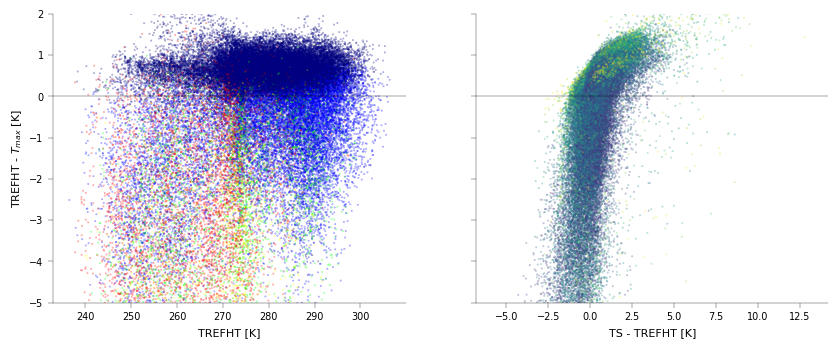

In [130]:
cmap = matplotlib.colors.ListedColormap(['navy', 'blue', 'lime', 'yellow', 'red'])
# Set color boundaries between integers
bounds = np.arange(-0.5, 5.5, 1)  # Centers each color on integer values
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
fig, ax = plt.subplots(1, 2, sharey=True)
isca_tools.plot.fig_resize(fig, 5*2)
ax[0].scatter(ds_use.TREFHT.where(ds_use.landmask>0).where(ds_use.lev_max>=0),
            (ds_use.TREFHT - ds_use.T_max).where(ds_use.landmask>0).where(ds_use.lev_max>=0),
            s=0.1, alpha=0.5, c=ds_use.lev_max, cmap=cmap, norm=norm)
ax[0].set_ylim(-5, 2)
ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[0].set_xlabel('TREFHT [K]')
ax[0].set_ylabel('TREFHT - $T_{max}$ [K]')

ax[1].scatter((ds_use.TS - ds_use.TREFHT).where(ds_use.landmask>0).where(ds_use.lev_max>=0),
            (ds_use.TREFHT - ds_use.T_max).where(ds_use.landmask>0).where(ds_use.lev_max>=0),
            s=0.1, alpha=0.5, c=(ds_use.U10).where(ds_use.landmask>0).where(ds_use.lev_max>=0), vmin=0, vmax=10)
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[1].set_xlabel('TS - TREFHT [K]')

plt.show()

### Combine latitudes
Here we consider all days at all latitudes above a given quantile of temperature and with $T_{max}$ occuring at a particular level.

In [23]:
def get_color_groups(n_groups=8, n_repeat=12, cmap='jet', repeat=True):
    base_cmap = plt.get_cmap(cmap)      # Choose a base continuous colormap
    # Extract 8 evenly spaced colors from the base colormap
    colors = [base_cmap(i / (n_groups - 1)) for i in range(n_groups)]
    # Repeat each color 12 times to get 96 colors
    repeated_colors = [color for color in colors for _ in range(n_repeat)]
    if repeat:
        repeated_colors = repeated_colors + repeated_colors[::-1]       # account for other hemisphere
    return repeated_colors

/home/users/jamd1/miniforge3/envs/myenv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


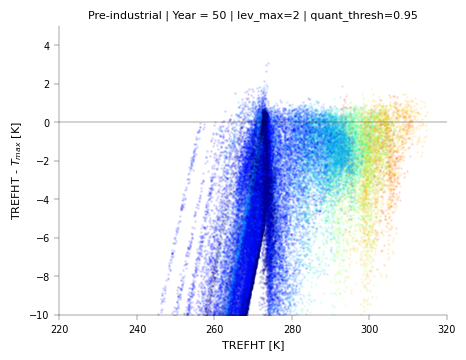

In [69]:
# Define discrete colormap
lev_max_plot = 0
quant_thresh = 0.95
colors_lat = get_color_groups()         # color by latitude
fig, ax = plt.subplots(1, 1)
isca_tools.plot.fig_resize(fig, 5)
for i in range(ds.lat.size):
    ds_use = ds.isel(lat=i)
    ds_use = ds_use.where(ds_use.landmask>0)
    if quant_thresh is not None:
        ds_use = ds_use.where(ds_use.TREFHT>ds_use.TREFHT.quantile(quant_thresh, dim='time'))
    if lev_max_plot is not None:
        ds_use = ds_use.where(ds_use.lev_max==lev_max_plot)
    ax.scatter(ds_use.TREFHT, (ds_use.TREFHT - ds_use.T_max), s=1, alpha=0.1, color=colors_lat[i])
ax.axhline(0, color='k', lw=ax_linewidth)
ax.set_xlabel('TREFHT [K]')
ax.set_ylabel('TREFHT - $T_{max}$ [K]')
ax.set_title(f'Pre-industrial | Year = {year_load} | lev_max={lev_max_plot} | quant_thresh={quant_thresh}')
ax.set_ylim(-10, 5)
ax.set_xlim(220, 320)
plt.show()

/home/users/jamd1/miniforge3/envs/myenv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/home/users/jamd1/miniforge3/envs/myenv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/home/users/jamd1/miniforge3/envs/myenv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/home/users/jamd1/miniforge3/envs/myenv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/home/users/jamd1/miniforge3/envs/myenv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/home/users/jamd1/miniforge3/envs/myenv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN

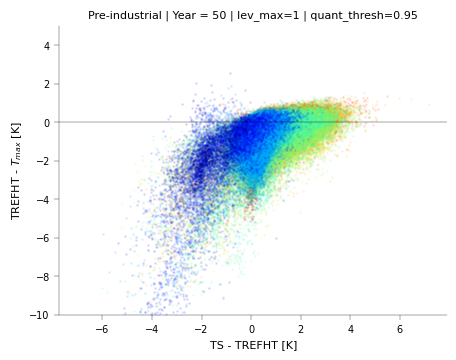

In [106]:
lev_max_plot = 1
quant_thresh = 0.95
colors_lat = get_color_groups()         # color by latitude
fig, ax = plt.subplots(1, 1)
isca_tools.plot.fig_resize(fig, 5)
for i in range(ds.lat.size):
    ds_use = ds.isel(lat=i)
    ds_use = ds_use.where(ds_use.landmask>0)
    if quant_thresh is not None:
        ds_use = ds_use.where(ds_use.TREFHT>ds_use.TREFHT.quantile(quant_thresh, dim='time'))
    if lev_max_plot is not None:
        ds_use = ds_use.where(ds_use.lev_max==lev_max_plot)
    ax.scatter(ds_use.TS-ds_use.TREFHT, (ds_use.TREFHT - ds_use.T_max), s=1, alpha=0.1, color=colors_lat[i])
ax.axhline(0, color='k', lw=ax_linewidth)
ax.set_xlabel('TS - TREFHT [K]')
ax.set_ylabel('TREFHT - $T_{max}$ [K]')
ax.set_title(f'Pre-industrial | Year = {year_load} | lev_max={lev_max_plot} | quant_thresh={quant_thresh}')
ax.set_ylim(-10, 5)
# ax.set_xlim(220, 320)
plt.show()

#### Check effect of clouds
Here I plot $T_s$-TREFHT vs the difference between clearsky and full shortwave radiation reaching the surface. This highlights the fact that the cloudier it is, the more equal $T_s$ and TREFHT.

Equally, the days where $T_{max} >$ TREFHT typically occur when it is not cloudy.

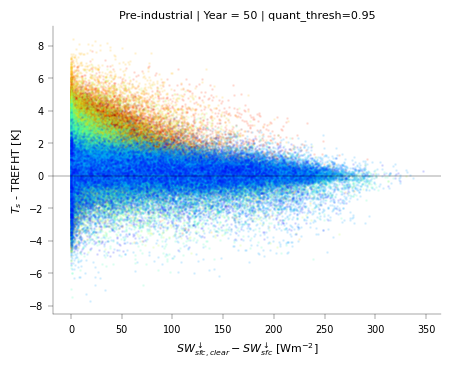

In [155]:
quant_thresh = 0.95
colors_lat = get_color_groups()         # color by latitude
show_surf_diff = True
fig, ax = plt.subplots(1, 1)
isca_tools.plot.fig_resize(fig, 5)
for i in range(ds.lat.size):
    ds_use = ds.isel(lat=i)
    if np.abs(float(ds_use.lat)) > 70:
        continue
    ds_use = ds_use.where(ds_use.landmask>0)
    if quant_thresh is not None:
        ds_use = ds_use.where(ds_use.TREFHT>ds_use.TREFHT.quantile(quant_thresh, dim='time'))
    ax.scatter(ds_use.FSDSC - ds_use.FSDS, (ds_use.TS - ds_use.TREFHT) if show_surf_diff else ds_use.TREFHT - ds_use.T_max,
               s=1, alpha=0.1, color=colors_lat[i])
ax.axhline(0, color='k', lw=ax_linewidth)
ax.set_xlabel('$SW^{\downarrow}_{sfc, clear} - SW^{\downarrow}_{sfc}$ [Wm$^{-2}$]')
ax.set_ylabel('$T_s$ - TREFHT [K]' if show_surf_diff else 'TREFHT - $T_{max}$ [K]')
ax.set_title(f'Pre-industrial | Year = {year_load} | quant_thresh={quant_thresh}')
if not show_surf_diff:
    ax.set_ylim(-10, 5)
# ax.set_xlim(220, 320)
plt.show()

### Fraction of days with a temperature inversion
Below I plot the fraction of days which have the TREFHT-$T_{max}$ temperature inversion to highlight that it occurs for most days.

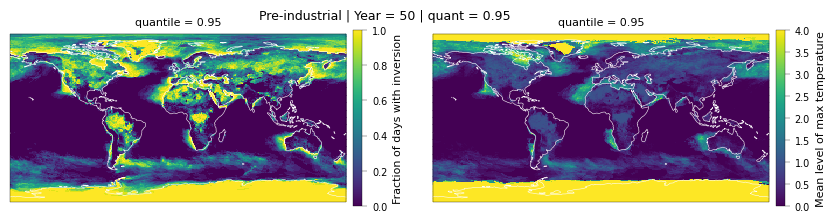

In [88]:
quant_thresh = 0.95
if quant_thresh is not None:
    ds_use = ds.where(ds.TREFHT>ds.TREFHT.quantile(quant_thresh, dim='time'))
else:
    ds_use = ds
inversion_frac = (ds_use.T_max > ds_use.TREFHT).sum(dim='time')/(ds_use.TREFHT>0).sum(dim='time')
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})
isca_tools.plot.fig_resize(fig, 5*2)
im = inversion_frac.plot(vmin=0, vmax=1, ax=ax[0], add_colorbar=False)
plt.colorbar(im, ax=ax[0], fraction=0.025, pad=0.02, label='Fraction of days with inversion')
im = ds_use.lev_max.mean(dim='time').plot(vmin=0, vmax=4, ax=ax[1], add_colorbar=False)
plt.colorbar(im, ax=ax[1], fraction=0.025, pad=0.02, label='Mean level of max temperature')
for i in range(len(ax)):
    ax[i].coastlines(lw=0.4, color='w')
fig.suptitle(f'Pre-industrial | Year = {year_load} | quant = {quant_thresh}', y=0.64, fontsize=9)
plt.show()